# Projet - Déserts Médicaux

## Eloïse Pollet & Sarah Vincent

Ce projet a pour but d'analyser les déserts médicaux en France, grâce à l'identification d'un ou plusieurs indices de déserts médicaux, par professions. Dans l'objectif de rendre visuelle cette analyse, nous utilisons un tableau de bord.

## Préparation des données

In [1]:
import pandas as pd
import os
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn import preprocessing
import ipywidgets as widgets
from ipywidgets import interact, interactive, fixed, interact_manual
from IPython.display import display
import warnings
warnings.filterwarnings("ignore")

In [2]:
# déclaration des constantes 
DATA_DIR = '../data/external/'
PROCESSED_DIR = '../data/processed/'

CITIES_FILENAME = 'base-cc-filosofi-2015.xls'
PS_CITIES_FILENAME= 'PS_communes.csv'
ANALYSIS_FILENAME = 'analyse_df.csv'

In [3]:
analyse_df = pd.read_csv(os.path.join(DATA_DIR, ANALYSIS_FILENAME), 
                         sep=';', 
                         dtype={'CODGEO': str, 'codecommuneetablissement': str},
                        )

In [4]:
#POUR AVOIR LA LISTE NUMEROTEE DES COLONNES EN CAS DE WARNING DU READ_CSV
list(enumerate(analyse_df.columns))

[(0, 'codecommuneetablissement'),
 (1, 'ambulance'),
 (2, 'analyse_medicale'),
 (3, 'autre'),
 (4, 'autre_specialiste'),
 (5, 'chirurgien'),
 (6, 'dentiste'),
 (7, 'generaliste'),
 (8, 'hopital'),
 (9, 'infirmiers'),
 (10, 'organe'),
 (11, 'radiologiste'),
 (12, 'reeducateur_podologue'),
 (13, 'CODGEO'),
 (14, 'LIBGEO'),
 (15, 'NBMENFISC15'),
 (16, 'NBPERSMENFISC15'),
 (17, 'MED15'),
 (18, 'PIMP15'),
 (19, 'TP6015'),
 (20, 'TP60AGE115'),
 (21, 'TP60AGE215'),
 (22, 'TP60AGE315'),
 (23, 'TP60AGE415'),
 (24, 'TP60AGE515'),
 (25, 'TP60AGE615'),
 (26, 'TP60TOL115'),
 (27, 'TP60TOL215'),
 (28, 'PACT15'),
 (29, 'PTSA15'),
 (30, 'PCHO15'),
 (31, 'PBEN15'),
 (32, 'PPEN15'),
 (33, 'PPAT15'),
 (34, 'PPSOC15'),
 (35, 'PPFAM15'),
 (36, 'PPMINI15'),
 (37, 'PPLOGT15'),
 (38, 'PIMPOT15'),
 (39, 'D115'),
 (40, 'D915'),
 (41, 'RD15'),
 (42, '_merge')]

In [5]:
analyse_df.shape

(35922, 43)

In [6]:
analyse_df.head()

,codecommuneetablissement,ambulance,analyse_medicale,autre,autre_specialiste,chirurgien,dentiste,generaliste,hopital,infirmiers,...,PPAT15,PPSOC15,PPFAM15,PPMINI15,PPLOGT15,PIMPOT15,D115,D915,RD15,_merge
0,01001,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,both
1,01002,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,both
2,01004,1.0,4.0,21.0,35.0,9.0,15.0,25.0,8.0,32.0,...,9.5,6.7,2.7,2.0,2.0,-15.8,10398.571429,33801.200000,3.250562,both
3,01005,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,4.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,both
4,01007,0.0,0.0,3.0,0.0,0.0,0.0,5.0,0.0,4.0,...,8.1,4.0,2.4,0.8,0.8,-15.1,13620.666667,34606.923077,2.540766,both


### 74 communes ne sont pas dans les deux ficihiers, nous les supprimons

In [7]:
analyse_df.loc[analyse_df.CODGEO.isnull()]['codecommuneetablissement'].str[:2].value_counts()

97    67
98     6
29     1
Name: codecommuneetablissement, dtype: int64

In [8]:
analyse_df.columns

Index(['codecommuneetablissement', 'ambulance', 'analyse_medicale', 'autre',
       'autre_specialiste', 'chirurgien', 'dentiste', 'generaliste', 'hopital',
       'infirmiers', 'organe', 'radiologiste', 'reeducateur_podologue',
       'CODGEO', 'LIBGEO', 'NBMENFISC15', 'NBPERSMENFISC15', 'MED15', 'PIMP15',
       'TP6015', 'TP60AGE115', 'TP60AGE215', 'TP60AGE315', 'TP60AGE415',
       'TP60AGE515', 'TP60AGE615', 'TP60TOL115', 'TP60TOL215', 'PACT15',
       'PTSA15', 'PCHO15', 'PBEN15', 'PPEN15', 'PPAT15', 'PPSOC15', 'PPFAM15',
       'PPMINI15', 'PPLOGT15', 'PIMPOT15', 'D115', 'D915', 'RD15', '_merge'],
      dtype='object')

### Nous créons un fichier pour une analyse par département, cela nous paraît plus intuitif de fonctionner par départements pour isoler les effets liés au territoire.

In [9]:
dept_df = (analyse_df
           .dropna(subset=['CODGEO','NBPERSMENFISC15']) #On enlève les NA de codgeo et qd on a pas le nb de personnes
          .assign(departement = lambda df: df.CODGEO.str[:2])
           .groupby('departement')
           [['NBPERSMENFISC15','ambulance', 'analyse_medicale', 'autre',
       'autre_specialiste', 'chirurgien', 'dentiste', 'generaliste', 'hopital',
       'infirmiers', 'organe', 'radiologiste', 'reeducateur_podologue']]
           .sum()
          )

### Création des variables d'analyse, nombre de professionnels pour 100 000 habitants

In [10]:
metiers = ['ambulance','analyse_medicale','autre','autre_specialiste','chirurgien','dentiste',
         'generaliste','hopital','infirmiers','organe','radiologiste','reeducateur_podologue']

for v in metiers :
    dept_df[v + '_100'] = 100000*dept_df[v]/dept_df.NBPERSMENFISC15

In [11]:
dept_df.columns

Index(['NBPERSMENFISC15', 'ambulance', 'analyse_medicale', 'autre',
       'autre_specialiste', 'chirurgien', 'dentiste', 'generaliste', 'hopital',
       'infirmiers', 'organe', 'radiologiste', 'reeducateur_podologue',
       'ambulance_100', 'analyse_medicale_100', 'autre_100',
       'autre_specialiste_100', 'chirurgien_100', 'dentiste_100',
       'generaliste_100', 'hopital_100', 'infirmiers_100', 'organe_100',
       'radiologiste_100', 'reeducateur_podologue_100'],
      dtype='object')

### Nous souhaitons créer un indice qui regrouperait tous les métiers pour parler de déserts médicaux. Cependant, nous souhaitons accorder un poids plus ou moins important en fonction des spécialités, certaines étant plus sollicitées que d'autres. En suivant ce lien https://www.orientation-pour-tous.fr/metiers-16/secteurs-qui-recrutent/article/cette-synthese-sur-les-metiers-de-la-sante-a, nous remarquons que les infirmiers, généralistes et hopitaux en font partie. Les kinésithérapeutes également, mais les variables ne nous permettent pas de les isoler.

In [12]:
dept_df['desert'] = ( (1.5*dept_df['generaliste_100']
                     +1.5*dept_df['hopital_100']
                     +1.5*dept_df['infirmiers_100']
                     +1*dept_df['ambulance_100']
                     +1*dept_df['radiologiste_100']
                     +1*dept_df['analyse_medicale_100']
                     +1*dept_df['autre_100']
                     +1*dept_df['chirurgien_100']
                     +1*dept_df['dentiste_100']
                     +1*dept_df['reeducateur_podologue_100']
                     +1*dept_df['organe_100']
                     +1*dept_df['autre_specialiste_100'])/13.5
)


In [13]:
dept_df['desert'] # Vérification

departement
01     62.408743
02     57.413353
03     70.664158
04    120.212602
05    142.018330
06    120.510176
07     81.708507
08     63.797680
09    105.083064
10     60.038344
11    101.305366
12     88.079210
13     91.103105
14     73.281367
15     81.695886
16     62.118203
17     85.673122
18     57.581461
19     86.767987
21     77.379757
22     74.261324
23     79.353657
24     79.554763
25     69.728804
26     88.677705
27     44.568501
28     46.112600
29     86.590367
2A    148.121687
2B    145.415271
         ...    
67     89.228977
68     64.561273
69     73.256568
70     56.892330
71     66.390300
72     51.092896
73     97.058178
74     79.141988
75     65.003882
76     62.304988
77     52.904573
78     62.054628
79     55.902720
80     71.605516
81     94.774255
82     84.911831
83    118.193324
84    103.670782
85     61.165430
86     65.433204
87     84.107973
88     61.857286
89     56.099685
90     58.874634
91     56.492035
92     70.990893
93     42.768772
94

### Lecture : Dans l'Ain, il y a environ 62 professionels de la santé pour 100 000 personnes.

# Représentation graphique

Nous créons un outil visuel qui représente les indices par départements.

In [14]:
dept_df['Departement'] = dept_df.index.values

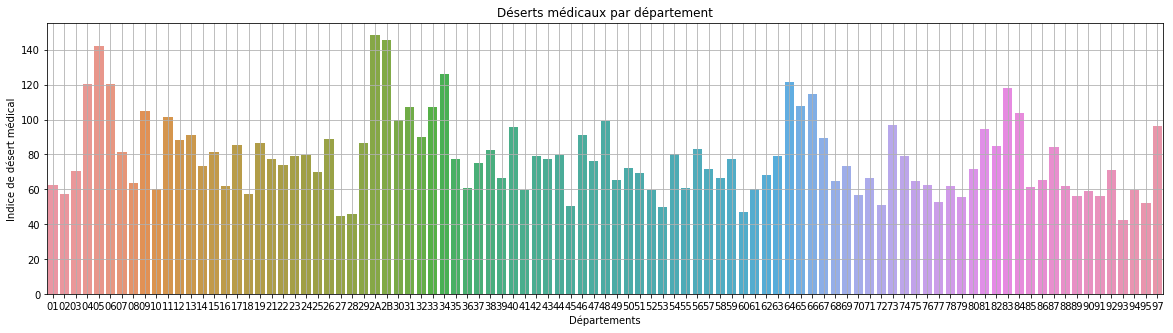

In [15]:
fig, ax = plt.subplots(figsize=(20, 5)) 
fam = sns.barplot(data=dept_df, y='desert', x='Departement')

# title and labels
plt.title("Déserts médicaux par département")
plt.xlabel("Départements")
plt.ylabel("Indice de désert médical")
plt.grid(True)

In [16]:
f = []
for v in dept_df.columns : 
    if v.endswith('ajusté') : 
        f.append(v)
d = dept_df[f]
d['somme'] = d.sum(axis=1)

In [17]:
x = d['somme'].values.reshape(-1,1) 
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)
d['score'] = x_scaled

In [18]:
a = widgets.ToggleButtons(
                          options = ['ambulance_100',
                                     'analyse_medicale_100',
                                     'autre_100',
                                     'autre_specialiste_100',
                                     'chirurgien_100',
                                     'dentiste_100',
                                     'generaliste_100',
                                     'hopital_100',
                                     'infirmiers_100',
                                     'organe_100',
                                     'radiologiste_100',
                                     'reeducateur_podologue_100',
                                    'desert'],
                          description = 'Spécialité :',
                          disabled = False,
                          button_style = ''
                         )
b = widgets.Select(
                   options = dept_df['Departement'].values.tolist(),
                   value = '01',
                   description = 'Departement :',
                   disabled = False
                  )

display(a,b)  

button = widgets.Button(description="Consulter l'indice")
display(button)

output = widgets.Output()

@output.capture()
def on_button_clicked(z):
    
    sns.barplot(data=dept_df, y=a.value.lower(), x='Departement')
    
button.on_click(on_button_clicked)
display(output)

ToggleButtons(description='Spécialité :', options=('ambulance_100', 'analyse_medicale_100', 'autre_100', 'autr…

Select(description='Departement :', options=('01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11',…

Button(description="Consulter l'indice", style=ButtonStyle())

Output()